In [95]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.model_selection import GridSearchCV
from scipy import stats

# Download the Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  if not os.path.isdir(housing_path):
    # housing_path olarak bir dizin yoksa bu dizini oluşturur
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path) # housing_url'deki veriyi indirip tgz_path dizininkedi dosyaya yükler.
  housing_tgz = tarfile.open(tgz_path) # tarfile modülü ile dosya açılır
  housing_tgz.extractall(path=housing_path) # housing_path dizinine tarfile'daki tüm içerikler çıkartılır.
  housing_tgz.close() # Açık dosyayı kapatıyor. Bu işlem sistem kaynaklarını serbest bırakma işine yarar ve sistem kaynakları daha efektif kullanılabilir.

In [4]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

# Take a Quick Look at the Data Structure

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()
# total_bedrooms değişkeninde eksik veriler olduğu anlaşılıyor 20443-20640, ayrıca ocean_proximity object tipinde bir değişken

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# Bu metot sayısal verilerin bir özetini gösterir.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


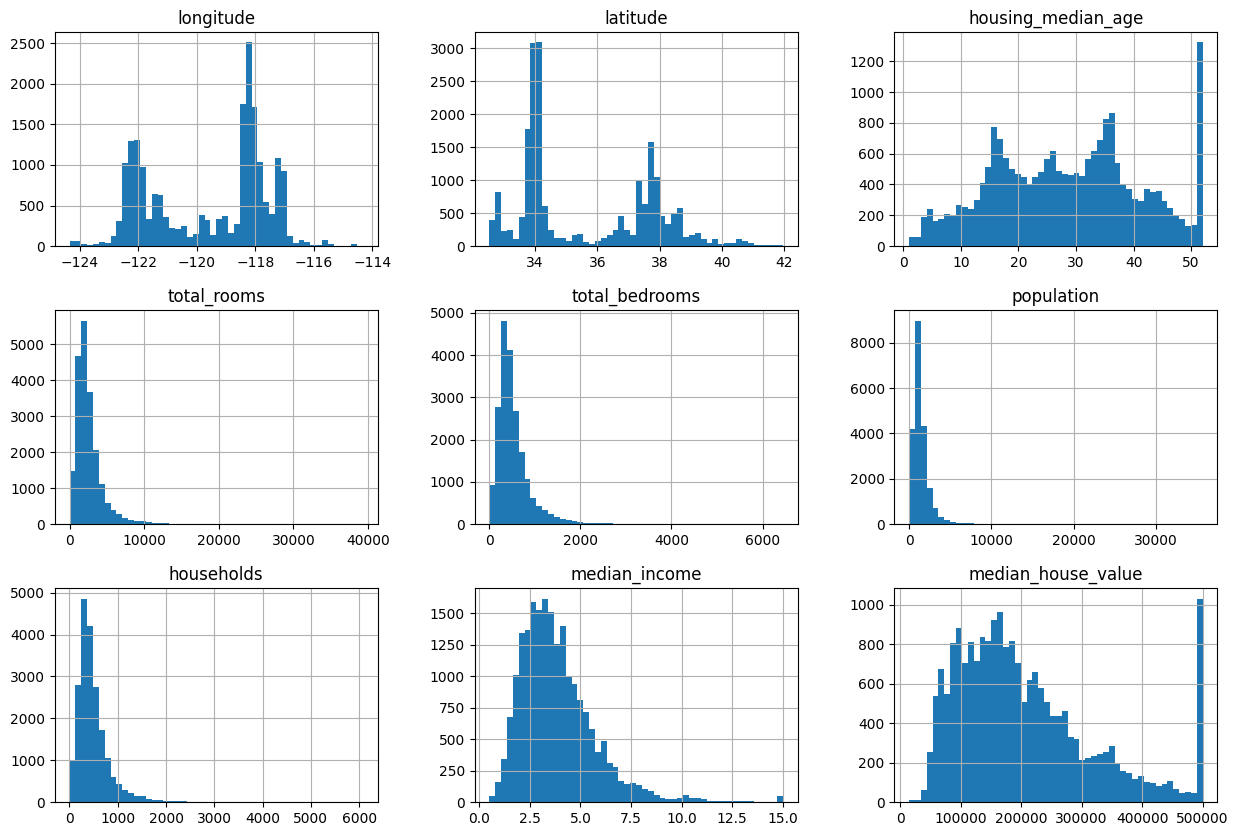

In [10]:
housing.hist(bins=50, figsize=(15, 10)) # bins değeri kutu sayısını belirler, histogram ise sayısal değerleri sıklığa göre görselleştirmek için kullanılır.
plt.show()

# Create a Test Set

**Data Snooping Bias:** Bir modelin geliştirilmesi sırasında veya bir analiz yapılırken veri seti üzerinde yapılan tekrarlı denemelerin, modelin gerçek performansı üzerinde olumsuz bir etkiye sahip olabilecek bir tür önyargı oluşturmasını ifade eder.
Bu tür bir önyargı, modelin eğitim setindeki hata oranlarını yanıltıcı bir şekilde düşük göstererek, modelin genelleme yeteneğini aşırı iyimser bir şekilde değerlendirmesine neden olabilir. Bu problemin temel nedeni, aynı veri setinde yapılan sürekli denemelerin, test seti başarısını arttırmasıdır çünkü model bu veriyi daha önce görmüştür.
- Problemle başa çıkmak için çapraz doğrulama, holdout seti kullanımı ve istatistiksel testler gibi yöntemler uygulanabilir.

In [11]:
# Bu fonksiyonun kullanımı, veri setini eğitim ve test setlerine rastgele bölmek ve modelin genelleme performansını değerlendirmek için yaygın bir yöntemdir.
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data)) # veri setindeki öğelerin indekslerini karıştırır ve rastgele bir sıralama elde ederiz.
  test_set_size = int(len(data) * test_ratio) # test setinin boyutunu belirliyoruz.
  test_indices = shuffled_indices[:test_set_size] # karıştırılmış indekslerden test seti kısmı
  train_indices = shuffled_indices[test_set_size:] # karıştırılmış indekslerden train seti kısmı
  return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

np.random.seed(42) gibi bir fonksiyonu
- shuffled_indices = np.random.permutation(len(data))

kısmından önce yazıp sürekli aynı test ve train set dağılımını alabilirdik fakat yeni veri seti geldiğinde, veri seti güncellendiğinde bu kod da artık çalışmaz bunun önüne geçebilmek için aşağıdaki fonksiyonlar bütün şartlar için aynı dağılımı yakalamamıza yardımcı olur.

In [13]:
# Bu fonksiyonlar identifier kullanarak test setine ait olanları belirler ve yeni gelen verilerden sonra da aynı dağılım korunabilir.
def test_set_check(identifier, test_ratio):
  # identifier her örneği temsil eden benzersiz bir kimlik değeridir
  # crc32 algoritması kullanılarak identifier değeri bir tamsayıya dönüştürülür, ikinci kısım ise test setinin oranını crc değeri ile karşılaştırmak için kullanılır.
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32 # değerler eşleşirse true döner yoksa false döner.

def split_train_test_by_id(data, test_ratio, id_column):
  # identifier için herhangi bir şey yoksa id sütunu identifier olarak kullanılabilir.
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) # her bir ids için test setine ait mi değil mi kontrol eder ve boolean dizisi üretir.
  return data.loc[~in_test_set], data.loc[in_test_set] # test setine ait olmayan ve olan örnekleri içeren dizileri döndürür.

Bu fonksiyonların işe yaraması için yeni gelen veriler en sona eklenmelidir ve herhangi bir veri silinmemelidir. Eğer böyle bir durum olursa en stable olan column, identifier olarak kullanılabilir

In [14]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
len(train_set), len(test_set)

(16512, 4128)

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
len(train_set), len(test_set)

(16322, 4318)

In [16]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

**Stratified Sampling:** Örneğin bir nüfus dağılımında %51.3 kadın ve %48.7 erkek dağılımı varsa ve bu dağılımdan bir sample almak istiyorsak aldığımız sampleda 513 kadın ve 487 erkek olabilir bu aynı oranı koruyacaktır ve biased bir model üretmemek için dikkat edilmesi gereken önemli bir noktadır.

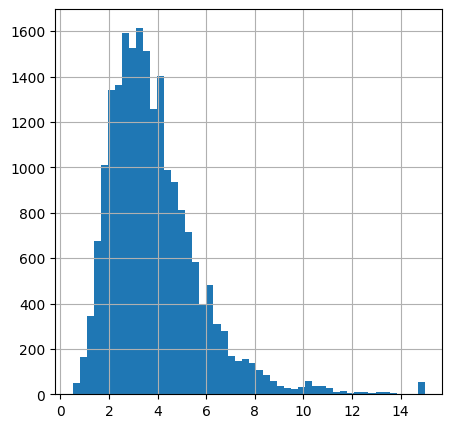

In [17]:
# Burada median_income özelliğini incelersek verilerin çoğu 1.5 ile 6 arasında görünüyor ve biased bir yapı olmaması için çoğunlukla bu aralıktan veri alınmalıdır.
housing["median_income"].hist(bins=50, figsize=(5,5))
plt.show()

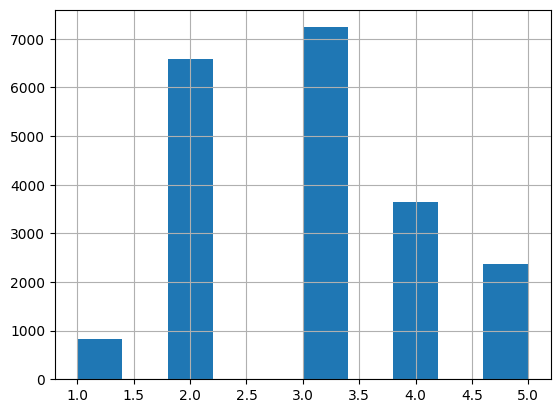

In [18]:
# pd.cut kullanarak yukarıdaki histogramı kategorilere ayırıyoruz ve oluşan görsele göre de sıklık durumuna göre StratifiedShuffle kullanacağız.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # bir defa bölme işlemi yapılır ve random_state ile aynı dağılım korunur.
for train_index, test_index in split.split(housing, housing["income_cat"]): # housing ve housing["income_cat"] kullanarak stratejik bir şekilde bölme işlemini gerçekleştirir.
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [20]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [21]:
# veri setini eski haline getirmek için
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [22]:
housing = strat_train_set.copy()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


## Visualizing Geographical Data

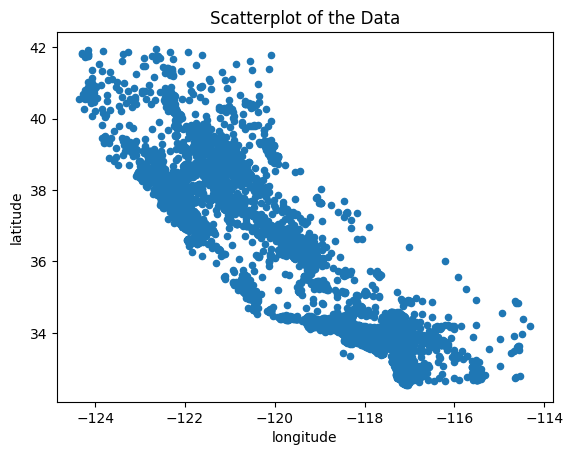

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.title("Scatterplot of the Data")
plt.show()

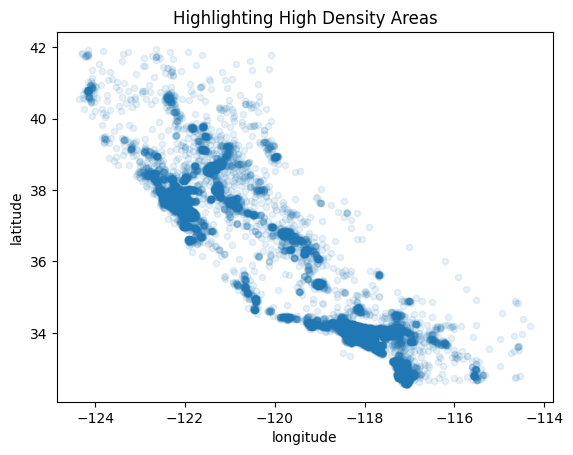

In [24]:
# High density data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.title("Highlighting High Density Areas")
plt.show()

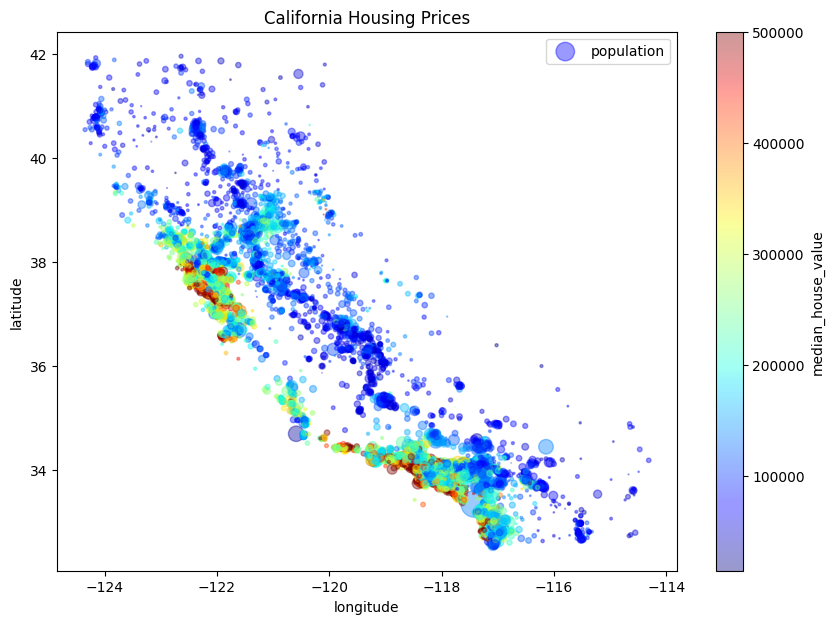

In [25]:
# Her circle bir district'in nüfusunu belirtiyor, renkler price belirtiyor, blue düşük ücret red ise yüksek ücrettir.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population",
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.title("California Housing Prices")
plt.legend()
plt.show()

## Looking for Correlations

In [28]:
# Correlation
corr_matrix = housing.corr()

<ipython-input-28-0d6b91029ccd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [29]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

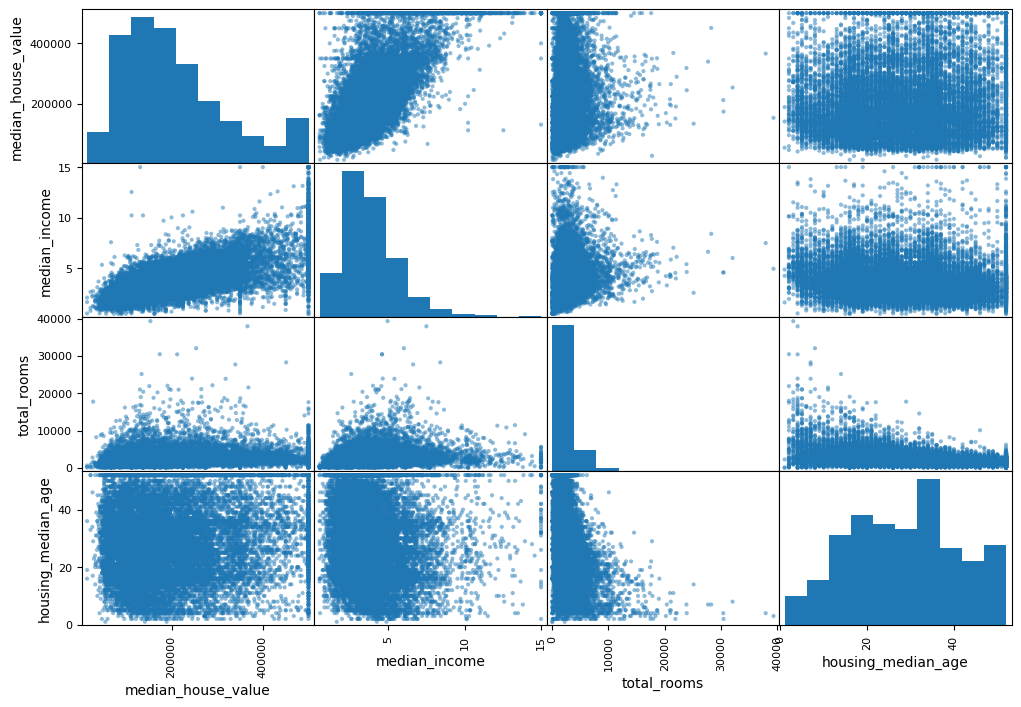

In [32]:
# from pandas.plotting import scatter_matrix correlation between attributes, plots every numerical attributes against every other numerical attribute
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

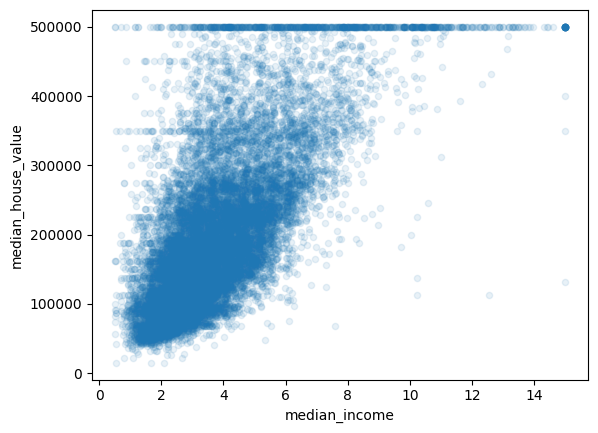

In [34]:
# güçlü korelasyon vardır çünkü trend sürekli yukarıya doğru gidiyor, 500.000, 450.000, 350.000, 250.000 gibi rakamlarda yatay dağılım price cap olabilir.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

### Experimenting with Attribute Combinations

In [35]:
# Sadece bedroom sayısı ya da room sayısı bir şey ifade etmeyebilir. Kişi başına düşen oda sayısını hesaplama mantıklı olabilir
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [36]:
# Tekrardan korelasyon matrix
# Sonuçlara göre total_bedrooms, total_rooms yerine bedrooms_per_room değişkeni daha yüksek korelasyon gösterdi ve bu mantıklı bir işlem oldu.
# bedrooms/rooms oranı düştükçe ev fiyatı yükseliyor denebilir.
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-36-d3b7ef651530>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [37]:
# .drop kopyasını oluşturur ve o sütunu siler, gerçek değişkene etki etmez
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [ ]:
# total_bedrooms değişkeni diğerlerinden daha az veri içeriyordu ve bu problemi çözmemi gerekiyor
  # housing.dropna(subset=["total_bedrooms"])  bu kısım boş verileri içeren tüm satırları siler
  # housing.drop("total_bedrooms", axis=1)  bu kısım tüm sütunu siler

# Aşağıdaki kısım ise median değerini bulup boş satırları median ile doldurur.
  # median = housing["total_bedrooms"].median()
  # housing["total_bedrooms"].fillna(median, inplace=True)

In [39]:
# from sklearn.impute import SimpleImputer bu fonksiyon sayesinde boş değerleri medyan değerlere kolaylıkla dönüştürebiliriz
imputer = SimpleImputer(strategy="median")

In [40]:
# Median değerini sadece sayısal değerlerde hesaplayabileceğimiz için object ve string tipindeki sütunları çıkartmamız gerekiyor
housing_num = housing.drop("ocean_proximity", axis=1)

In [41]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
# Şu an için total_bedrooms değişkeninde boş değerler var fakat yeni değerler için diğerlerinde de olabilir ve bu değerler kullanılabilir.
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [43]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
X = imputer.transform(housing_num)
X.shape

(16512, 8)

In [48]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


## Handling Text and Categorical Attributes

In [49]:
# ocean_proximity categorical attribute olduğu için bunun üzerine fikir üreteceğiz
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [51]:
# bu kategorileri text yapısında number yapısına çevireceğiz (from sklearn.preprocessing import OrdinalEncoder)
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # fit ve transform ayrı uygulamak yerine fit_transform tüm işlemi tekte yapar
housing_cat_encoded

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [52]:
# tüm kategorilerin listesi
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Not:** Sayılar bir büyüklük ifade ettiği için makine öğrenmesi algoritmaları 0,1,2,3,4 gibi değerlerin her birine farklı davranır ve yakın değerleri birbirine yakınmış anlamı çıkartır. Bu değerler sıralanmış(ordered) kategoriler için uygun olabilir(bad, average, good, excellent gibi) fakat bu problemde bir büyüklük küçüklük anlamı olmadığından dolayı bu bir problem oluşturur ve bunu çözmek için de her özelliğe ait one binary attribute kullanacağız yani **OneHotEncoder**

In [54]:
# from sklearn.preprocessing import OneHotEncoder 1(hot)-0(cold), yeni özelliklere dummy variables da denebilir
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
# Sonuç bir Sparse Matrix döndürecek ve bu numPy arrayden daha mantıklı bir seçimdir çünkü çok fazla sütuna sahipsek 1 tane pozitif değer dışında diğer hepsi 0 olarak gözükecek
# Sparse Matrix non-zero değerlerin lokasyonunu tutar ve daha az memory harcar. Yine de numPy array döndürmek istiyorsak aşağıdaki kod işe yarayabilir.
# housing_cat_1hot.toarray()

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [55]:
# kategorilerin listesi
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [57]:
# from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipelines and Feature Scaling

In [59]:
# from sklearn.pipeline import Pipeline, from sklearn.preprocessing import StandardScaler
# pipeline uygulanacak adımları tanımlar ve sırayla uygular
# son estimator'a kadar yani bu örnek için standardscaler tüm aşamalarda fit() uygular sonuncudan sonra transform() da uygular.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [61]:
# from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# bu özellik sayısal ve kategorili değişkenler için ayrı ayrı özellik uygulamaya yarar, numerical değerler için num_pipeline ve categorical için OneHotEncoder örneği var.
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model

### Training and Evaluating on the Training Set

In [63]:
# from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [65]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [67]:
# from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # neredeyse $68.627 dolarlık hata yapmış ve bu kötü bir model denebilir, bunu çözmek için daha güçlü bir model deneyelim

68627.87390018745

In [69]:
# from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse # model overfit olmuş görünüyor tabi buna çözüm bulmak için train, validation ayrımı ve diğer işlemler yapılabilir. (Aşağıda)

0.0

### Better Evaluation Using Cross-Validation

In [72]:
# Çözümlerden biri veri setini train, validation, test olarak ayırmaktır.
# Diğer bir yöntem ise K-fold cross-validation yöntemidir bu da küçük setlere bölüp (her varyasyon için)modeli birden çok kez eğitir ve en iyi sonucu alır.

# from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10) # neg_mean_squared_error skor büyüyünce daha iyi performans der.
# cross_val_score utility function bekler yani büyük değeri esas alır, cost function ise küçük değeri bulmaya çalışır mse,rmse'de olduğu gibi bunun için -scores kullandık.
tree_rmse_scores = np.sqrt(-scores)

In [73]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

# sonuçlar LinearRegression kısmından da kötü görünüyor.
display_scores(tree_rmse_scores)

Scores: [71749.32410216 70211.08334597 69205.59842664 73054.34127808
 69768.1996761  77404.87885969 69274.89458255 73064.97252676
 67032.19810989 72873.49633024]
Mean: 71363.89872380755
Standard deviation: 2762.846253410493


In [74]:
# Same scores for the Linear Regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_score = np.sqrt(-lin_scores)
# Decision Tree model overfittin olduğu için Linear modelden daha kötü sonuç veriyor.
display_scores(lin_rmse_score)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


In [79]:
# Ensemble Modellerin bir diğeri RandomForest deneyelim
# from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [51002.69127053 48958.31376064 46619.91207325 52303.21353698
 47551.45144556 51889.12933812 52764.93421254 49806.42438951
 48453.91180503 54178.55543465]
Mean: 50352.85372668026
Standard deviation: 2338.2146200395173


In [80]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
# RandomForestRegressor sonuçları daha iyi fakat hala training sonuçları validation sonuçlarından çok daha düşük görünüyor (overfitting)

18775.17843107663

In [ ]:
# import joblib
# Aşağıdaki işlem eğittimiz modeli kaydetmek ve sonra tekrar çağırmak için kullanılabilir
"""
joblib.dump(my_model, "my_model.pkl")

my_model_loaded = joblib.load("mymodel.pkl")"""

## Fine-Tune Your Model

### Grid Model

In [84]:
# from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

# param_grid kısmı ilk dictionary için 3x4=12 deneme, 2. kısım için 2x3=6 deneme toplamda 18 deneme yapacak cv=5 olduğu için her biri 5 deneme 18x5=90 kez train edecek
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
# en iyi parametre kombinasyonunu bulma
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [88]:
# best estimator directly
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [90]:
# Tüm kombinasyonların sonuçlarını aşağıdaki gibi bastırabiliriz.
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

64589.38993335525 {'max_features': 2, 'n_estimators': 3}
55321.14607097036 {'max_features': 2, 'n_estimators': 10}
52563.007180105385 {'max_features': 2, 'n_estimators': 30}
61109.45807555938 {'max_features': 4, 'n_estimators': 3}
52677.971077284055 {'max_features': 4, 'n_estimators': 10}
50375.35843970151 {'max_features': 4, 'n_estimators': 30}
58277.02597800915 {'max_features': 6, 'n_estimators': 3}
52087.91382653705 {'max_features': 6, 'n_estimators': 10}
49952.37078018339 {'max_features': 6, 'n_estimators': 30}
59138.4024170167 {'max_features': 8, 'n_estimators': 3}
52358.39428625513 {'max_features': 8, 'n_estimators': 10}
50243.22975561128 {'max_features': 8, 'n_estimators': 30}
61587.35538197602 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54056.24032804145 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59311.65351871867 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52423.76248469764 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

### Randomized Search
GridSearch tüm kombinasyonları denediği için büyük bir aralıkta tüm kombinasyonlar aşırı maliyetli olabilir bunun yerine RandomizedSearch iyi bir seçenektir ve
rastgele sayıdaki rastgele kombinasyonları inceler ve ona göre sonuç verir.

## Ensemble Methods


### Analyze the Best Models and Their Errors

In [91]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.30862141e-02, 6.23592964e-02, 4.21774895e-02, 1.89962816e-02,
       1.61176886e-02, 1.70127942e-02, 1.62295464e-02, 3.57513655e-01,
       3.52973910e-02, 1.07158127e-01, 8.25357600e-02, 1.27329495e-02,
       1.50632289e-01, 1.04387915e-04, 4.14554799e-03, 3.90058083e-03])

In [92]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3575136553545086, 'median_income'),
 (0.15063228903943748, 'INLAND'),
 (0.10715812744861931, 'pop_per_hhold'),
 (0.08253576003694943, 'bedrooms_per_room'),
 (0.07308621414254302, 'longitude'),
 (0.062359296446078155, 'latitude'),
 (0.04217748954102044, 'housing_median_age'),
 (0.03529739099639531, 'rooms_per_hhold'),
 (0.018996281627926173, 'total_rooms'),
 (0.017012794178371378, 'population'),
 (0.016229546431066992, 'households'),
 (0.01611768856744772, 'total_bedrooms'),
 (0.012732949453704262, '<1H OCEAN'),
 (0.004145547988482765, 'NEAR BAY'),
 (0.003900580832552759, 'NEAR OCEAN'),
 (0.00010438791489622119, 'ISLAND')]

### Evaluate Your System on the Test Set

In [94]:
# Tüm işlemlerden sonra modeli değerlendirme kısmı geldi burada test setini fit etmemize gerek yoktur sadece transform yeterli

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48321.610394318675

In [96]:
# Güven aralığı ayarlamak isteyebiliriz from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46335.08159746, 50229.63543126])